### This notebook does some basic exporatory data analysis for predicting mobile case theme 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from __future__ import print_function,division
from PIL import Image as pil_img
import cv2
from glob import glob
import os
import hashlib
import seaborn as sns
from scipy.misc import imresize
import json
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
#set your path here
basepath = '/home/tftuts/WindowShare/data/mobile_theme/'

I've found that a lot of images seem to be duplicate in the training set.Let's find out 

In [3]:
hashes = {}
labels = {}

print('computing md5 of training data:')

for base_dir in ['train']:
    print(base_dir)
    for fname in glob(basepath+base_dir+'/*/*.jpg'):
        labels[fname] = fname.split('/')[-2]
        h = hashlib.md5(open(fname,'rb').read()).hexdigest()  
        if h in hashes:
            hashes[h].append(fname)
        else:
            hashes[h] = [fname]

print(len(hashes))            

computing md5 of training data:
train
4154


In [4]:
if not os.path.exists('hash2img.txt'):
    with open('hash2img.txt', 'w') as f:
        json.dump(hashes, f)
else:
    with open('hash2img.txt','r') as f:
        hashes = json.load(f)

In [5]:
repeated = sum(1 for k,v in hashes.items() if len(v) > 1 )
print('files appearing more than once in train:',repeated)

files appearing more than once in train: 388


Since most of the deep learning algorithms use mini-batch learning, identical images with same labels may not have as 
-ve effect on the model as identical images with different labels

In [6]:
print('Identical files with different labels:')
for k,v in hashes.items():
    if len(v) > 1:
        c = set([labels[x] for x in v])
        if len(c) > 1:
            print(v,c)


Identical files with different labels:
[u'/home/tftuts/WindowShare/data/mobile_theme/train/Graffiti_and_Illustrations/Img10626.jpg', u'/home/tftuts/WindowShare/data/mobile_theme/train/Typography/Img1731.jpg'] set(['Graffiti_and_Illustrations', 'Typography'])
[u'/home/tftuts/WindowShare/data/mobile_theme/train/Movies_and_TV_shows/Img1770.jpg', u'/home/tftuts/WindowShare/data/mobile_theme/train/Spiritual/Img1773.jpg', u'/home/tftuts/WindowShare/data/mobile_theme/train/Superheroes/Img1772.jpg'] set(['Spiritual', 'Superheroes', 'Movies_and_TV_shows'])
[u'/home/tftuts/WindowShare/data/mobile_theme/train/Patterns_and_Ethnic/Img4194.jpg', u'/home/tftuts/WindowShare/data/mobile_theme/train/Signs_and_Symbols/Img4196.jpg'] set(['Patterns_and_Ethnic', 'Signs_and_Symbols'])
[u'/home/tftuts/WindowShare/data/mobile_theme/train/Famous_Personalities/Img4307.jpg', u'/home/tftuts/WindowShare/data/mobile_theme/train/Famous_Personalities/Img4309.jpg', u'/home/tftuts/WindowShare/data/mobile_theme/train/Spo

In [7]:
max_k='temp';max_v=0
for k,v in hashes.items():
    if len(v) > max_v:
        max_v = len(v)
        max_k = k

print('Most number of duplicate images - {},{}'.format(max_k,max_v))

Most number of duplicate images - 0dee99056e280ff5f69df116eb8f887a,4


let's make sure if they are identical

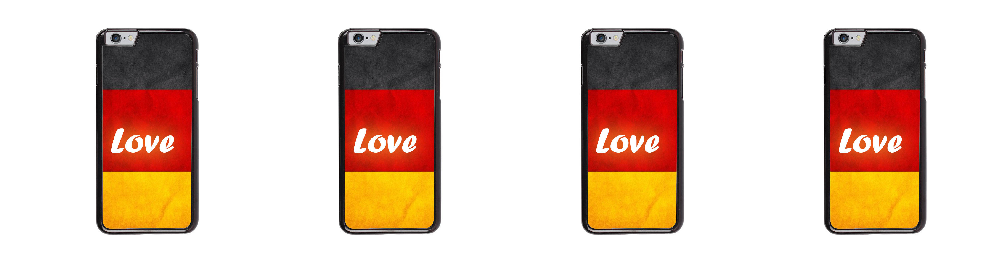

In [8]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



plots([plt.imread(fname) for fname in hashes[max_k]])        

Let's explore the test set to check if there are any of them in the training set as well

In [9]:
leaks = []
for fname in glob(basepath+'test/*/*.jpg'):
    h = hashlib.md5(open(fname,'rb').read()).hexdigest()
    if h in hashes:
        leaks.append((fname,hashes[h]))

print('Number of test images present in train:{}'.format(len(leaks)))        

Number of test images present in train:385


Let's have a look at some of the duplicate images

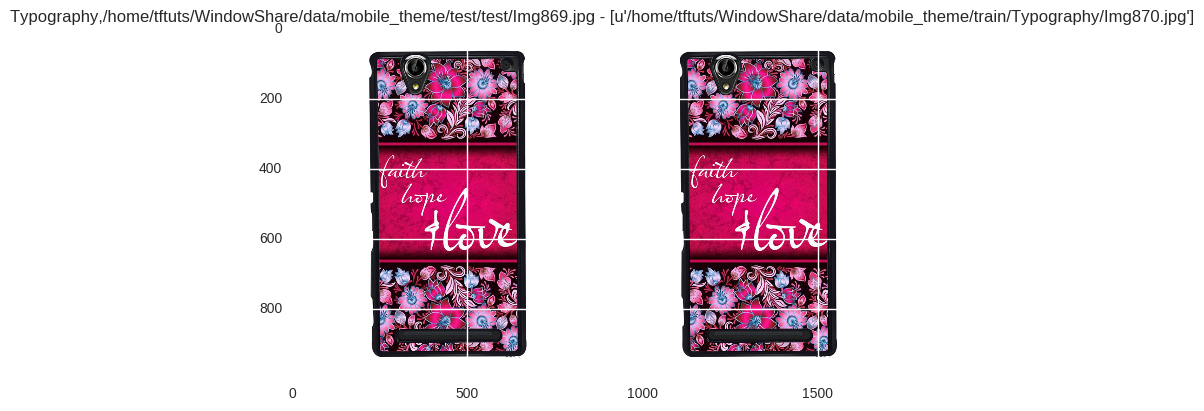

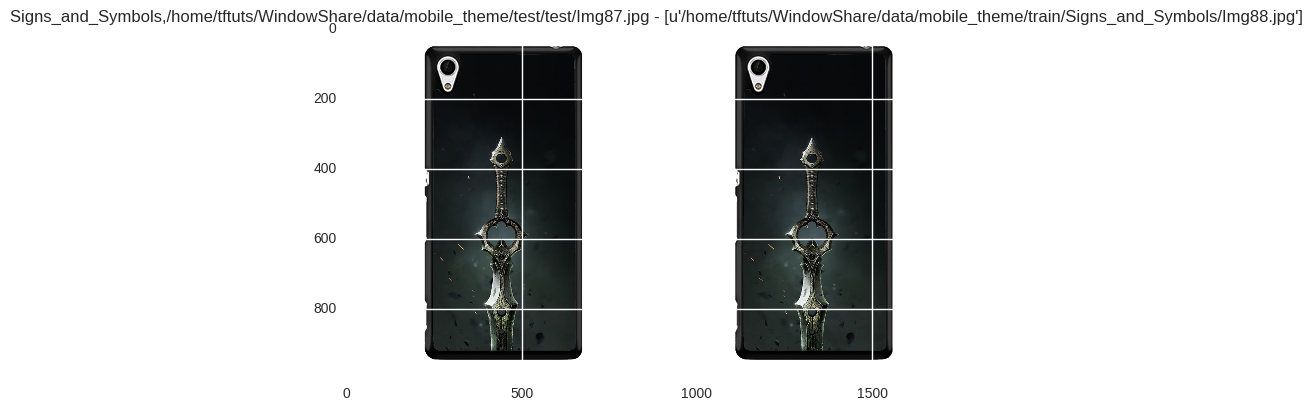

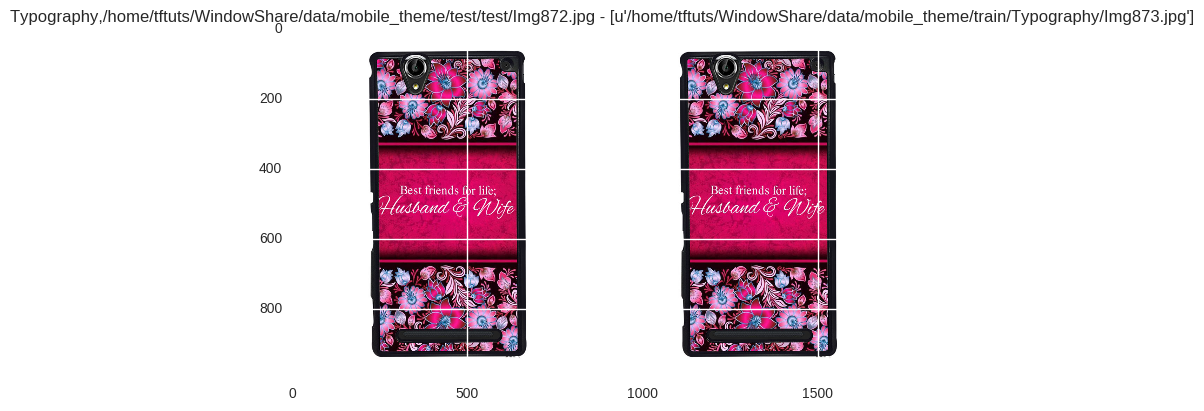

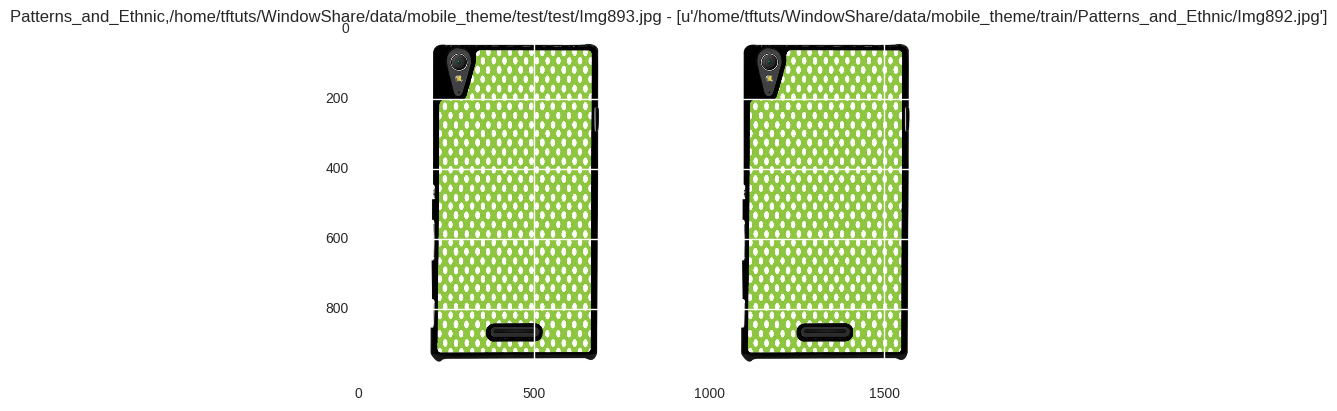

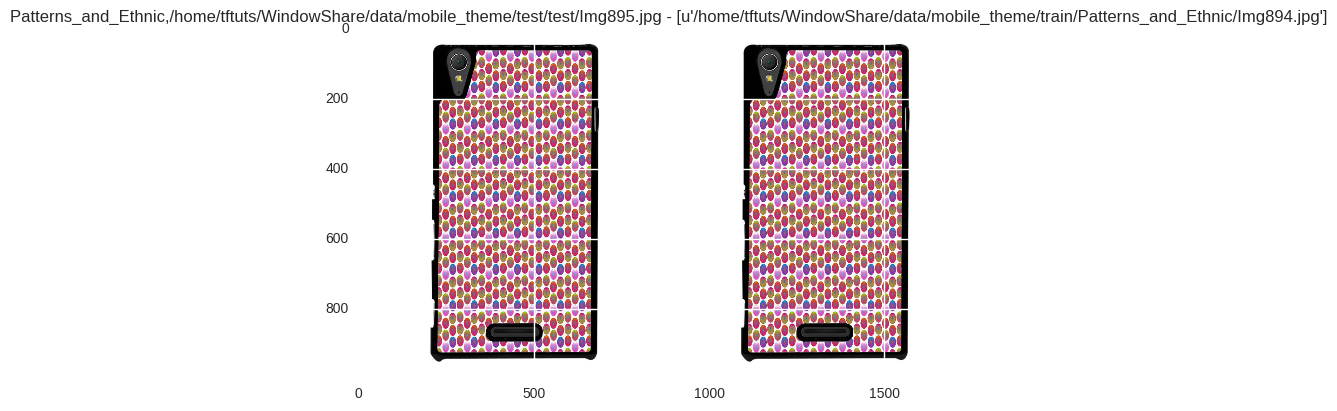

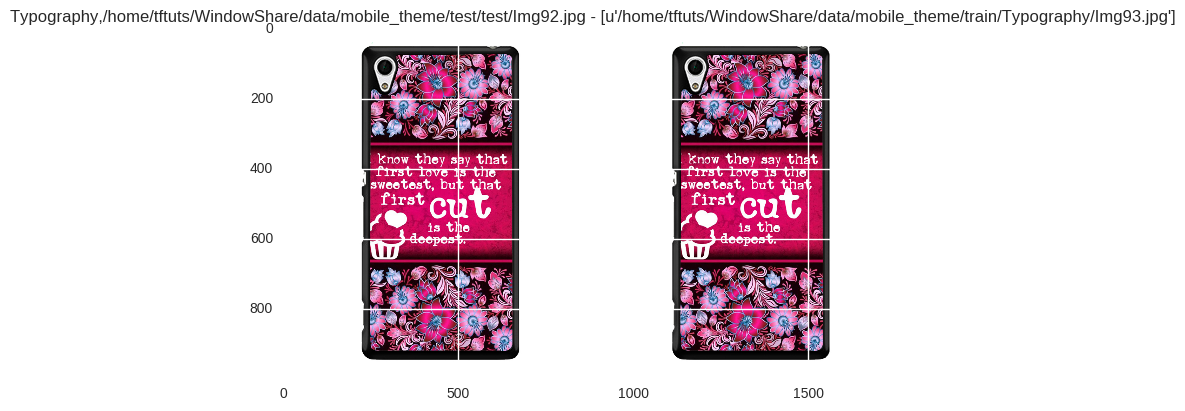

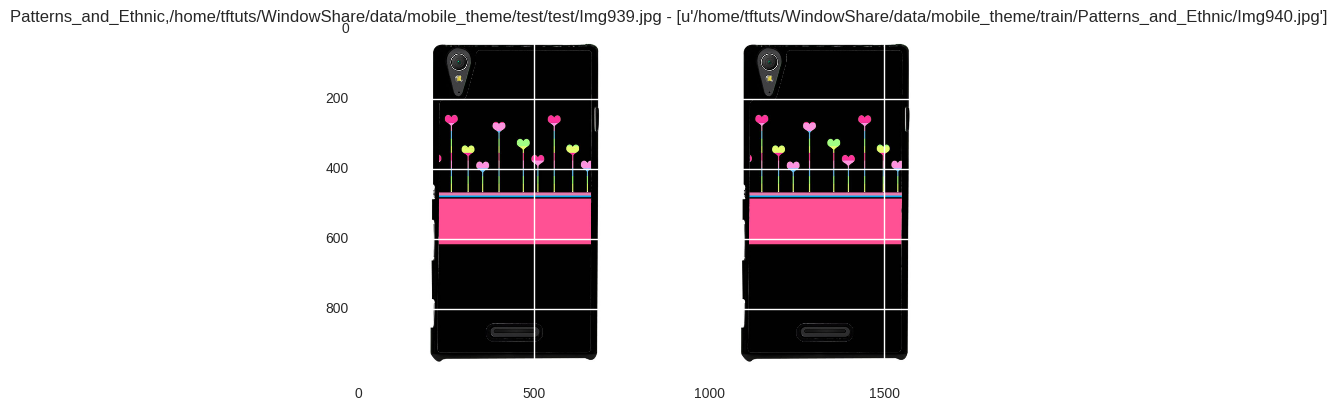

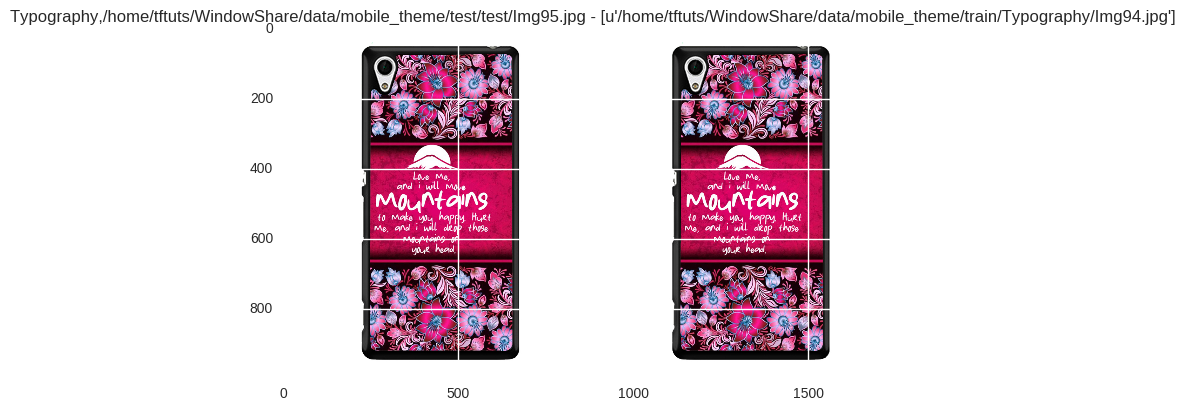

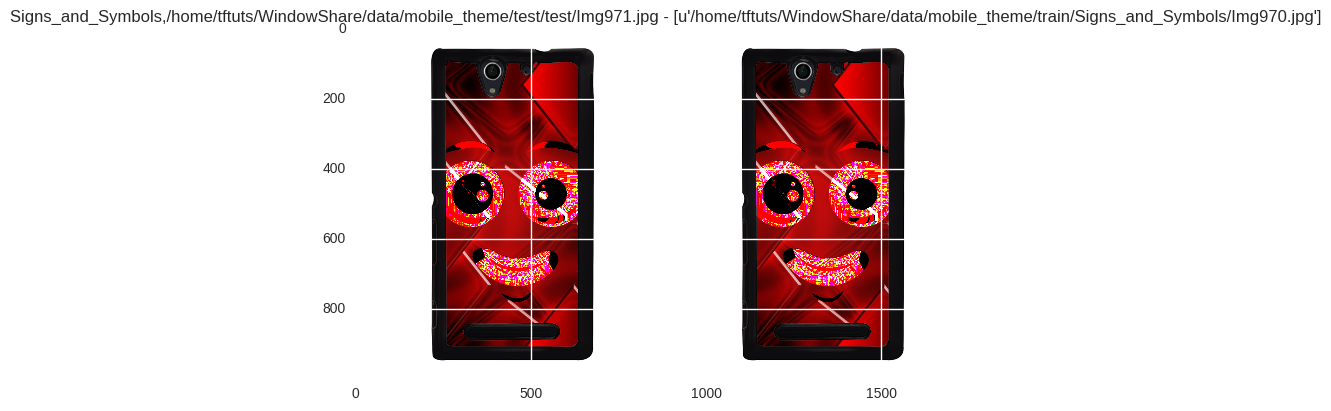

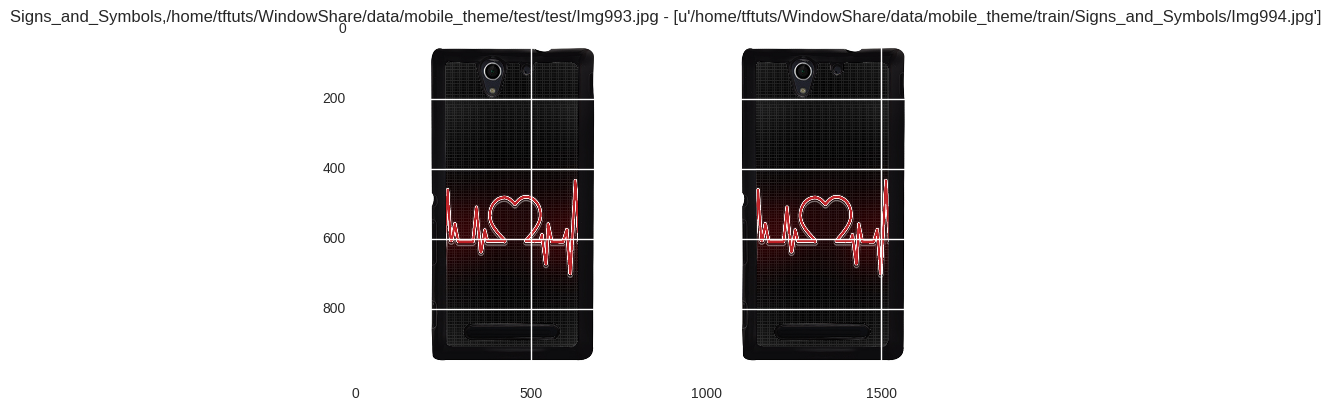

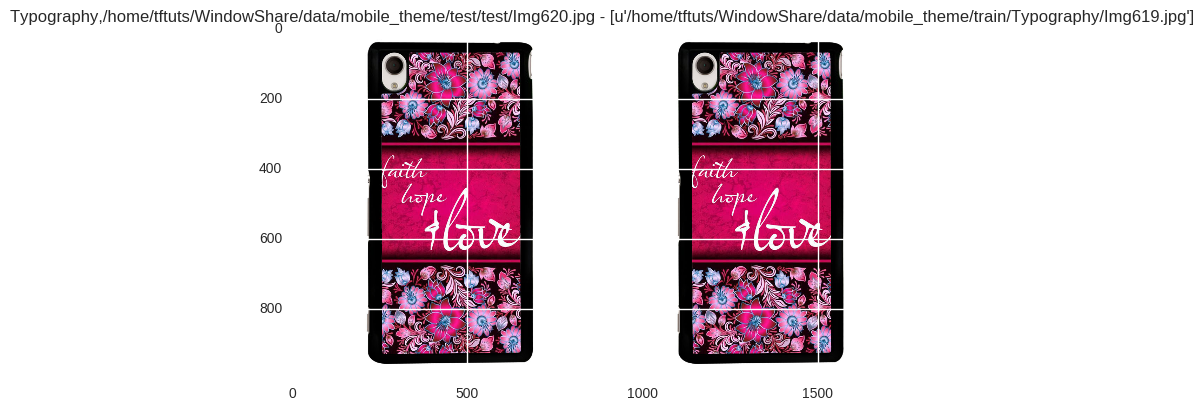

In [10]:
counter = 0
for t1,t2 in leaks:
    plt.figure()
    plt.title('{},{} - {}'.format(t2[0].split('/')[-2],t1,t2))
    plt.imshow(np.hstack([plt.imread(t1),plt.imread(t2[0])]))
    counter +=1
    if counter > 10:
        break


let's dig deep into the training set 

In [11]:
all_case_images = []

for path in sorted(glob(basepath+'train/*')):
    case_type = path.split('/')[-1]
    case_images = sorted(glob(basepath+'train/'+case_type+'/*'))
    all_case_images = all_case_images + case_images
    
all_case_images = pd.DataFrame({'imagepath':all_case_images})
all_case_images['filetype'] = all_case_images.apply(lambda row: row.imagepath.split('.')[-1],axis=1)
all_case_images['type'] = all_case_images.apply(lambda row: row.imagepath.split('/')[-2],axis=1)
all_case_images.head(6)

imagepath filetype        type
0  /home/tftuts/WindowShare/data/mobile_theme/tra...      jpg  Automobile
1  /home/tftuts/WindowShare/data/mobile_theme/tra...      jpg  Automobile
2  /home/tftuts/WindowShare/data/mobile_theme/tra...      jpg  Automobile
3  /home/tftuts/WindowShare/data/mobile_theme/tra...      jpg  Automobile
4  /home/tftuts/WindowShare/data/mobile_theme/tra...      jpg  Automobile
5  /home/tftuts/WindowShare/data/mobile_theme/tra...      jpg  Automobile

We have a total of 4591 images in the whole dataset


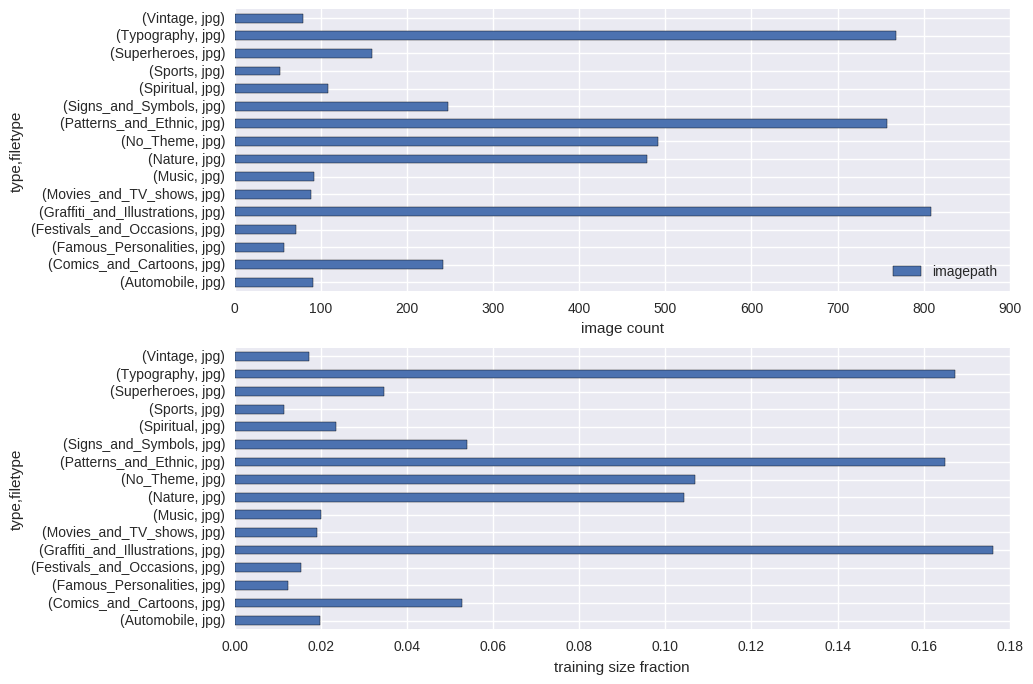

In [12]:
print('We have a total of {} images in the whole dataset'.format(all_case_images.shape[0]))
type_aggregation = all_case_images.groupby(['type','filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_case_images.shape[0],
                                           axis=1)

fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(10,8))
type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel('image count')
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel('training size fraction')

Let's have a look at 1 sample image from each class

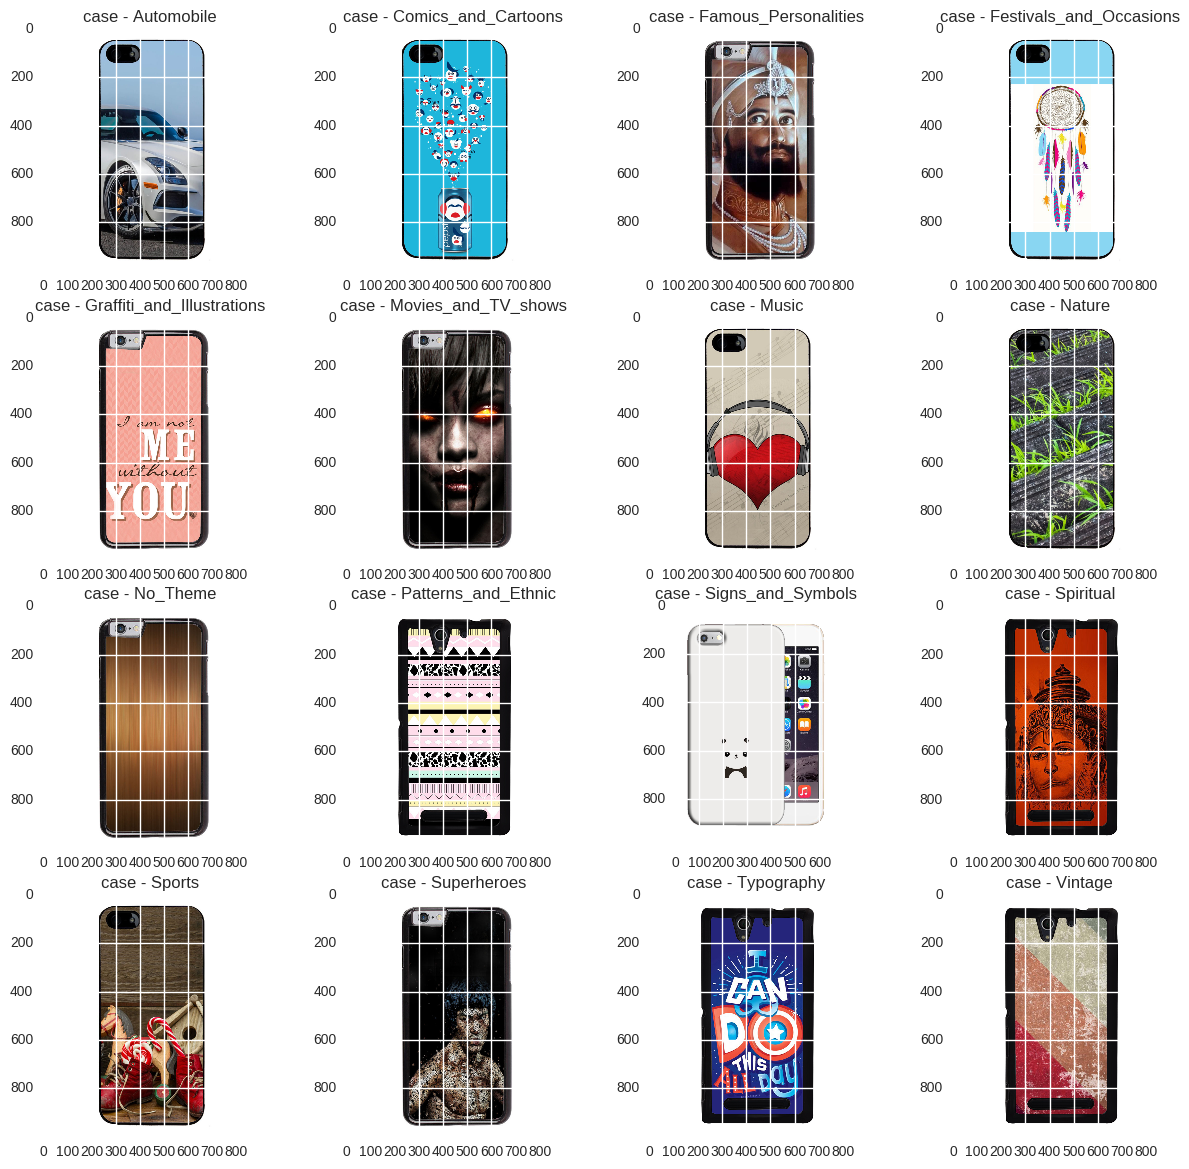

In [13]:
fig = plt.figure(figsize=(15,18))
i = 1
for t in all_case_images['type'].unique():
    ax = fig.add_subplot(5,4,i)
    i+=1
    f = all_case_images[all_case_images['type']==t]['imagepath'].values[0]
    plt.imshow(plt.imread(f))
    plt.title('case - {}'.format(t))

##### Let's have a look at unique image shapes  per class

In [14]:
cols = ['Type','shape']
shapes = pd.DataFrame(columns=cols)


for i,row in all_case_images.iterrows():
    size = plt.imread(row.imagepath).shape
    case_type = row.imagepath.split('/')[-2]
    shapes.loc[i] = [case_type,size]
     

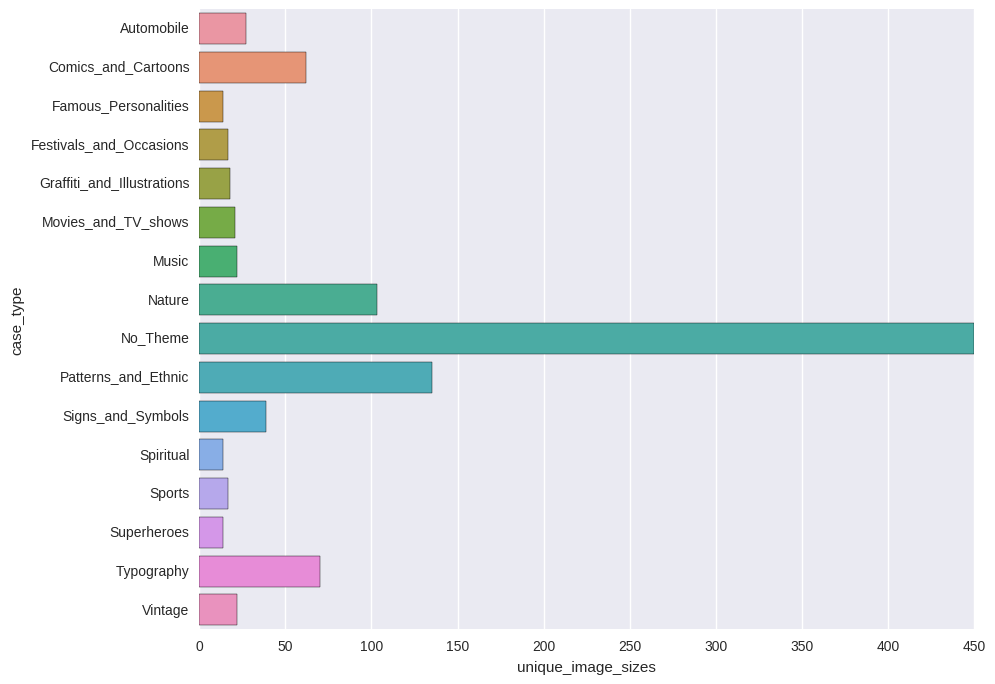

In [15]:
group = shapes.groupby('Type')['shape'].nunique()
plt.figure(figsize=(10,8))
ax = sns.barplot(x=group.values, y=group.index)
ax.set(xlabel='unique_image_sizes', ylabel='case_type')
plt.show()

### TSNE embedding
TSNE is a dimensionality reduction technique invented by Geoff Hinton and Laurens van der Maaten.We'll try to visualize some of the images after reducing their dimensions to 3.

In [16]:
from collections import defaultdict
images = defaultdict(list)

for t in all_case_images['type'].unique():
    sample_counter = 0
    for _,row in all_case_images[all_case_images['type']==t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = plt.imread(row.imagepath)
            sample_counter +=1
            if len(img.shape) < 3:
                img = np.expand_dims(img,axis=2)
                img = np.tile(img,3)
            if img.shape[2] == 4:
                img = img[:,:,:3]
                
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 35:
            break


In [17]:

def transform_image(img, rescaled_dim, to_gray=False):
    resized = cv2.resize(img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)
    
    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
    else:
        resized = resized.astype('float')
    
    normalized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
    timg = normalized.reshape(1, np.prod(normalized.shape))
    
    return timg/np.linalg.norm(timg)

rescaled_dim = 100

all_images = []
all_image_types = []

for t in all_case_images['type'].unique():
    all_images = all_images + images[t] 
    all_image_types = all_image_types + len(images[t])*[t]

gray_all_images_as_vecs = [transform_image(img, rescaled_dim) for img in all_images]    
print(gray_all_images_as_vecs[0].shape)
gray_imgs_mat = np.array(gray_all_images_as_vecs, dtype=object).squeeze()
all_image_types = np.array(all_image_types)
gray_imgs_mat.shape, all_image_types.shape

(1, 30000)


((576, 30000), (576,))

In [18]:
from sklearn.manifold import TSNE
tsne = TSNE(
        n_components=3,
        init='random',
        random_state=1001,
        method='barnes_hut',
        n_iter=500,
        verbose=2).fit_transform(gray_imgs_mat)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.121184
[t-SNE] Iteration 25: error = 0.9306579, gradient norm = 0.0140584
[t-SNE] Iteration 50: error = 0.8096150, gradient norm = 0.0113313
[t-SNE] Iteration 75: error = 0.6569315, gradient norm = 0.0111462
[t-SNE] Iteration 100: error = 0.4792507, gradient norm = 0.0012981
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.479251
[t-SNE] Iteration 125: error = 0.3839878, gradient norm = 0.0023907
[t-SNE] Iteration 150: error = 0.3407741, gradient norm = 0.0011344
[t-SNE] Iteration 175: error = 0.3268271, gradient norm = 0.0007862
[t-SNE] Iteration 175: gradient norm 0.000786. Finished.
[t-SNE] Error after 175 iterations: 0.479251


In [19]:
from sklearn import preprocessing

trace1 = go.Scatter3d(
            x=tsne[:,0],
            y=tsne[:,1],
            z=tsne[:,2],
            mode='markers',
            marker=dict(
                    sizemode='diameter',
                    color=preprocessing.LabelEncoder().fit_transform(all_image_types),
                    colorscale='Portland',
                    colorbar=dict(title='case_type'),
                    line=dict(color='rgb(255, 255, 255)'),
                    opacity=0.9))

data = [trace1]
layout = dict(height=800, width=800, title='3D embedding of images')
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

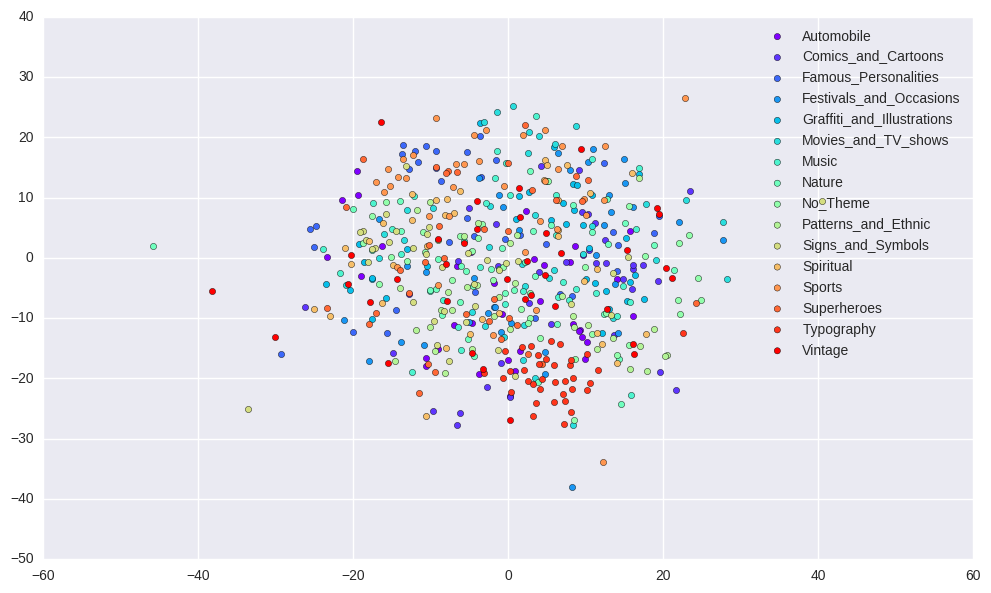

In [21]:
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, 16))
plt.figure(figsize=(12,7))

for i,t in enumerate(all_case_images['type'].unique()):
    tsne_t = tsne[np.where(all_image_types==t), :][0]
    sub = plt.scatter(tsne_t[:,0], tsne_t[:,1], c=colors[i], label=t)
plt.legend()
plt.show()

The clustering is not obvious but we can see some groupings amongst them ,especially vintage

### Special cases
There are some images that show the front side of the mobile as well, like these

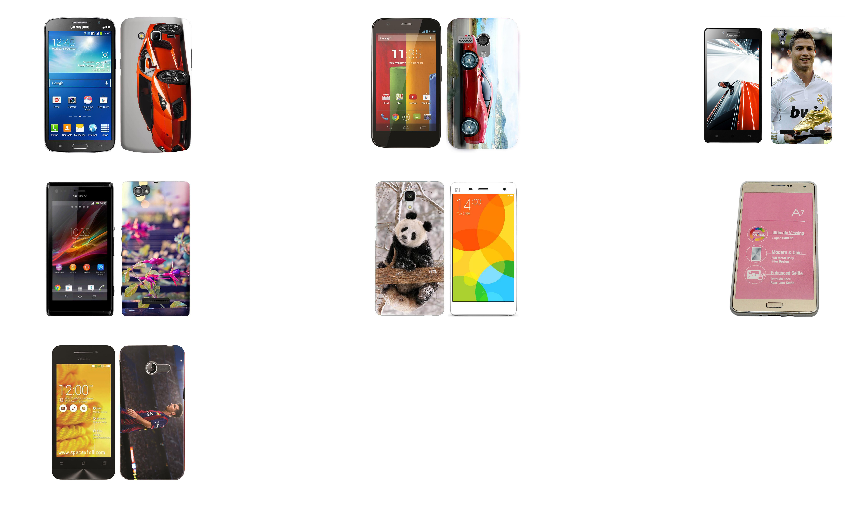

In [22]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows+1, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


special = ['Automobile/Img3018.jpg','Automobile/Img3072.jpg','Famous_Personalities/Img2481.jpg'
            ,'Nature/Img2507.jpg','Nature/Img2612.jpg','No_theme/Img2396.jpg','Sports/Img2479.jpg']

plots([plt.imread(basepath+'train/'+img) for img in special], rows=3)

Maybe cropping the unnecessary parts in the training set (by a bounding box?) will be ideal

### References
1) https://www.kaggle.com/philschmidt/intel-mobileodt-cervical-cancer-screening/cervix-eda-model-selection

2) https://www.kaggle.com/aamaia/intel-mobileodt-cervical-cancer-screening/leeak

3) https://github.com/fastai/courses